In [73]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import random
import albumentations as A
import paste
from instaboostfast import InstaBoost
import json
import getcoco

In [74]:
%matplotlib inline

In [75]:
data_dir = '../../data'
image_dir = 'images'
label_dir = 'labels'
crop_image_dir = 'c_images'
crop_label_dir = 'c_labels'
annotation_dir = 'annotations'
source_image_dir = 'src_images'
source_label_dir = 'src_labels'
aug_image_dir = 'new_images'
aug_label_dir = 'new_labels'
mask_dir = 'new_masks'

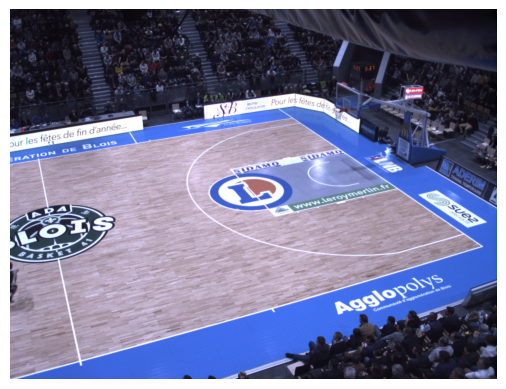

In [76]:
input_path = '../../data/src_images/0_aug/KS-FR-BLOIS_24330_1513711368928_1:1.png'
output_path = '../../data/new_images/KS-FR-BLOIS_24330_1513711368928_1:1.png'
input_image = cv2.imread(input_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
plt.imshow(input_image)
plt.axis('off')
plt.show()

In [77]:
def average_close_points(points, threshold):
    averaged_points = []
    while len(points) > 0:
        current_point = points[0]
        close_points = [current_point]
        remaining_points = []

        for point in points[1:]:
            distance = np.linalg.norm(np.array(current_point) - np.array(point))
            if distance <= threshold:
                close_points.append(point)
            else:
                remaining_points.append(point)

        averaged_point = np.mean(np.array(close_points), axis=0)
        averaged_points.append(averaged_point.tolist())
        points = remaining_points

    return averaged_points

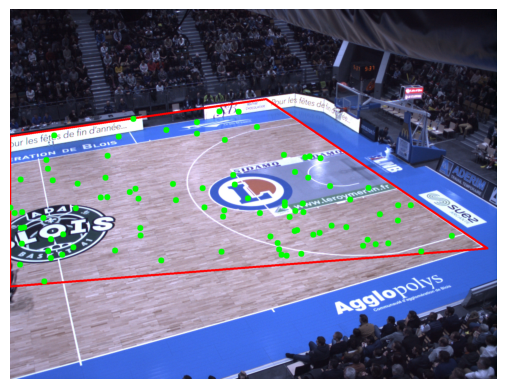

In [78]:
image = cv2.imread(input_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w = image.shape[:2]
if '_0.png' in input_path:
    right = 0
else:
    right = 1

image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
_, thresholded = cv2.threshold(image_gray, 120, 150, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
filtered_contours = []
blank_image = np.zeros_like(image)
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 100000:  # Adjust the threshold as needed
        filtered_contours.append(contour)
cv2.drawContours(blank_image, filtered_contours, -1, (0, 255, 0), 2)

gray = cv2.cvtColor(blank_image, cv2.COLOR_RGB2GRAY)
# Apply Hough Line Transform to detect straight lines
lines = cv2.HoughLinesP(gray, rho=1, theta=np.pi/180, threshold=50, minLineLength=100, maxLineGap=10)

# Draw the detected lines on the original image
min_line_length = 300
blank_image_2 = np.zeros_like(image)
enlarged_lines = []
scale_factor = 3.5
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        line_length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        if line_length > min_line_length:
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2
            dx = x2 - x1
            dy = y2 - y1

            # Compute the new endpoint coordinates
            new_x1 = center_x - int(dx * scale_factor / 2)
            new_y1 = center_y - int(dy * scale_factor / 2)
            new_x2 = center_x + int(dx * scale_factor / 2)
            new_y2 = center_y + int(dy * scale_factor / 2)

            # Append the enlarged line to the list of enlarged lines
            enlarged_lines.append([[new_x1, new_y1, new_x2, new_y2]])
            
for line in enlarged_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(blank_image_2, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Find intersections of line segments
filtered_intersections = []
if enlarged_lines is not None:
    for i in range(len(enlarged_lines)):
        for j in range(i+1, len(enlarged_lines)):
            x1, y1, x2, y2 = enlarged_lines[i][0]
            x3, y3, x4, y4 = enlarged_lines[j][0]
            
            m1 = (y2-y1)/(x2-x1)
            m2 = (y4-y3)/(x4-x3)
            
            if m1 != m2: #The lines intersect
                intersect_x = ((m1 * x1) - (m2 * x3) + y3 - y1) / (m1 - m2)
                intersect_y = m1 * (intersect_x - x1) + y1
                if x1 < intersect_x and intersect_x < x2 and y1 < intersect_y and intersect_y < y2: #the intersection is inside the lines
                    
                    # Get the direction vectors of the lines
                    v1 = (x2 - x1, y2 - y1)
                    v2 = (x4 - x3, y4 - y3)
                    
                    # Calculate the magnitudes of the direction vectors
                    v1_magnitude = np.sqrt(v1[0] ** 2 + v1[1] ** 2)
                    v2_magnitude = np.sqrt(v2[0] ** 2 + v2[1] ** 2)
                    
                    # Normalize the direction vectors
                    v1_normalized = (v1[0] / v1_magnitude, v1[1] / v1_magnitude)
                    v2_normalized = (v2[0] / v2_magnitude, v2[1] / v2_magnitude)

                    # Calculate the dot product of the normalized vectors
                    dot_product = v1_normalized[0] * v2_normalized[0] + v1_normalized[1] * v2_normalized[1]

                    # Calculate the intersection angle in radians
                    angle_radians = np.arccos(dot_product)

                    # Convert the angle to degrees
                    angle_degrees = np.degrees(angle_radians)
                    #print(angle_radians, angle_degrees)
                    if angle_degrees > 25:
                        filtered_intersections.append((intersect_x, intersect_y))
            
filtered_intersections = average_close_points(filtered_intersections, 80)

for point in filtered_intersections:
    intersect_x, intersect_y = point
    cv2.circle(blank_image_2, (int(intersect_x), int(intersect_y)), radius=10, color=(0, 0, 255), thickness=-1)

gray = cv2.cvtColor(blank_image_2, cv2.COLOR_RGB2GRAY)
# Apply Hough Line Transform to detect straight lines
new_lines = cv2.HoughLinesP(gray, rho=1, theta=np.pi/180, threshold=50, minLineLength=100, maxLineGap=10)
blank_image_3 = np.zeros_like(image)
for line in new_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(blank_image_3, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Get the points most to the right or left 
extreme_points = []
for line in new_lines:
    x1, y1, x2, y2 = line[0]
    if right == 1:
        if x1 == 0:
            extreme_points.append((x1,y1))
    else:
        if x2 == w-1:
            extreme_points.append((x2,y2))

# Compare the points to get the topmost and bottomost
topmost_point = None
bottommost_point = None
for point in extreme_points:
    x, y = point
    if topmost_point is None or y < topmost_point[1]:
        topmost_point = (x, y)
    if bottommost_point is None or y > bottommost_point[1]:
        bottommost_point = (x, y)
if topmost_point != None and bottommost_point != None:
    x, y = topmost_point
    if y < h//3:
        topmost_point = (x, h//3)
    elif y > h//2:
        topmost_point = (x, h//2)
    x, y = bottommost_point
    if y > 5*h//6:
        bottommost_point = (x, 5*h//6)
    elif y < 3*h//4:
        bottommost_point = (x, 3*h//4)
    
    cv2.circle(blank_image_2, topmost_point, radius=10, color=(0, 0, 255), thickness=-1)
    cv2.circle(blank_image_2, bottommost_point, radius=10, color=(0, 0, 255), thickness=-1)

# Get top and bot intersections
top_inter = None
bot_inter = None
for point in filtered_intersections:
    x, y = point
    if top_inter is None or y < top_inter[1]:
        top_inter = (x, y)
    if bot_inter is None or y > bot_inter[1]:
        bot_inter = (x, y)

# In case any point is not detected, apply 2022 winner's method
if top_inter == None or bot_inter == None or topmost_point == None or bottommost_point == None or top_inter == bot_inter or top_inter == topmost_point or bot_inter == bottommost_point or topmost_point == bottommost_point:
    if right == 1:
        topmost_point = (0, h//2 - h//5)
        top_inter = (w - w//5, h//2 - h//5)
        bot_inter = (w - w//5, h//2 + h//5)
        bottommost_point = (0, h//2 + h//5)
    else:
        top_inter = (w//5, h//2 - h//5)
        topmost_point = (w, h//2 - h//5)
        bottommost_point = (w, h//2 + h//5)
        bot_inter = (w//5, h//2 + h//5)
    
if right == 1:
    final_points = [topmost_point, top_inter, bot_inter, bottommost_point]
    min_x = 0
    max_x = bot_inter[0]
    min_y = bottommost_point[1]
    max_y = top_inter[1]
else:
    final_points = [top_inter, topmost_point, bottommost_point, bot_inter]
    min_x = bot_inter[0]
    max_x = w
    min_y = bottommost_point[1]
    max_y = top_inter[1]

final_points = np.array(final_points, dtype=np.int32)
cv2.polylines(image, [np.array(final_points)], isClosed=True, color=(255, 0, 0), thickness=6)


# Create pasting area
hull = cv2.convexHull(final_points)
cont = 0
finish = False
while not finish:
    point_inside = False
    while not point_inside:
        random_x = random.uniform(min_x, max_x)
        random_y = random.uniform(min_y, max_y)
        distance = cv2.pointPolygonTest(hull, (random_x, random_y), measureDist=False)
        if distance > 0:
            point_inside = True
    random_point = (int(random_x), int(random_y))
    cv2.circle(image, random_point, radius=10, color=(0, 255, 0), thickness=-1)
    cont = cont + 1
    if cont == 90:
        finish = True
        
plt.imshow(image)
plt.axis('off')
plt.show()

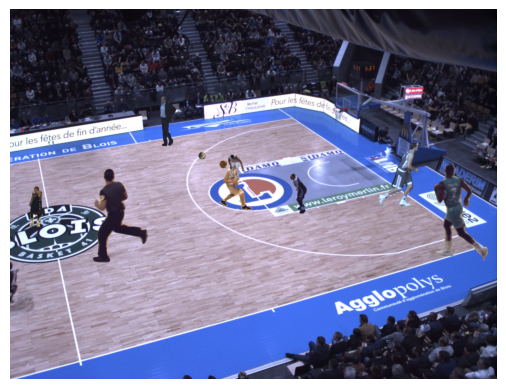

In [79]:
ball_number = 2
human_number = 8
paste.paste_object(input_path, ball_number, human_number)
output_image = cv2.imread(output_path)
output_1 = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
plt.imshow(output_1)
plt.axis('off')
plt.show()

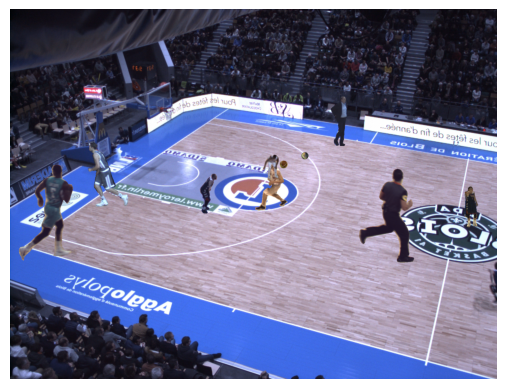

In [80]:
input_path = input_path.replace('src_images/0_aug', 'new_images')
paste.apply_random_augmentation(input_path)
output_image = cv2.imread(output_path)
output_2 = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
plt.imshow(output_2)
plt.axis('off')
plt.show()